In [211]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

The purpose of this notebook is to establish a basic econometric library for the course Econometrics II, and specifically to create a framework for replicating OxMetrics functionalities in Python.

The dataset for the assignment consists of mink fur prices from 1980-2023 (see Assignment_1.csv), and the goal is to "estimate a univariate time series model for the dynamic behavior of the price of mink fur and produce a forecast for the next 9 years. Compare your forecast with the provided compensation price.

The compensation price is the average price of the last 10 years, excluding the highest and lowest price. The compensation price is then
$$\frac{1}{8}(\sum_{i=2010}^{2020}P_i-\max(P_i)-\min(P_i))\quad\forall\ i\in[2010,2020]$$
$$=\frac{401+503+324+387+234+259+218+198}{8}=315,5$$


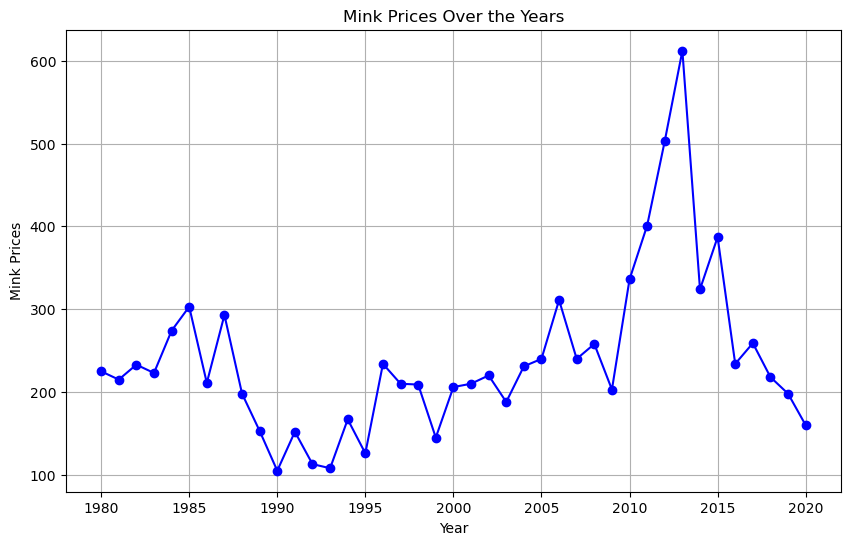

In [212]:
# load data and label variables
data = pd.read_csv("Assignment_1.csv")
data['log_P'] = np.log(data['P'])
data['log_diff_P'] = data['log_P'].diff()

# Create a plot
plt.figure(figsize=(10, 6))
plt.plot(data['year'], data['P'], marker='o', linestyle='-', color='b')

# Adding labels and title
plt.xlabel('Year')
plt.ylabel('Mink Prices')
plt.title('Mink Prices Over the Years')

# Show the plot
plt.grid(True)
plt.show()

As seen on the graph, the process does not appear stationary. We will have to do something about that!

In [213]:
# Check that math is correct and calculate average price
def average_price_exclude_extremes(df, start_year, end_year):
    # Filter the data and extract prices for the given range of years
    prices = df.loc[(df['year'] >= start_year) & (df['year'] <= end_year), 'P']
    
    # Exclude the highest and lowest prices
    prices_without_extremes = prices.drop([prices.idxmax(), prices.idxmin()])
    
    # Calculate and return the average
    return prices_without_extremes.mean()

# Call the function for the years 2011-2020
average = average_price_exclude_extremes(data, 2011, 2020)

print(f'The average mink price for 2011-2020, excluding the highest and lowest prices, is: {average}')

The average mink price for 2011-2020, excluding the highest and lowest prices, is: 315.5


Above we see that the math from before checks out, and the average price is indeed 315.5 DKK.

Now we need to make the data stationary, we make two transformations, the log and the difference:
$$\Delta P_t = P_t-P_{t-1} P$$
$$\Delta \log P_t = \log P_t-\log P_{t-1}$$

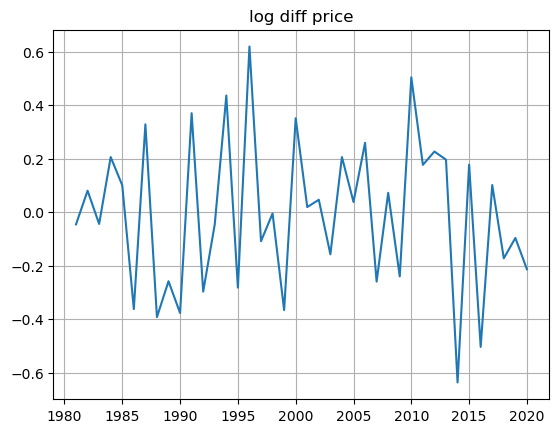

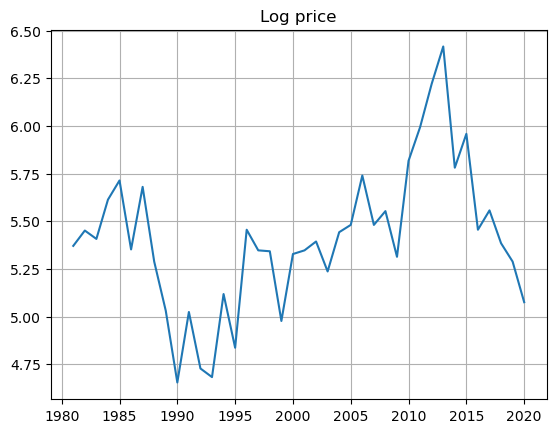

In [214]:
data = data.dropna()

plt.plot(data['year'], data['log_diff_P'])
plt.title("log diff price")
plt.grid(True)
plt.show()

plt.plot(data['year'], data['log_P'])
plt.title("Log price")
plt.grid(True)
plt.show()

Both of these could be stationary (in the assignment, a visual inspection is enough, but let's be thorough), so to check we make an Augmented Dickey-Fuller (ADF) test. The null hypothesis is that the time series is non-stationary, and the alternative hypothesis is that it is stationary.

In [215]:
from statsmodels.tsa.stattools import adfuller

adfuller(data['log_diff_P'])

(-9.132196795950627,
 3.0011016579954795e-15,
 0,
 39,
 {'1%': -3.610399601308181,
  '5%': -2.939108945868946,
  '10%': -2.6080629651545038},
 8.977578333869054)

From the results, the test statistic is -9.13 and the p-value is 3.00e-15, which is far below the 5% requirement level of .05, and we can reject the null hypothesis. The time series is therefore stationary, which is nice.

Now we can proceed with the actual modelling. The ARMA model with $p$ lags is given by
$$\Delta\log P_t=\delta+\theta_1 \Delta\log P_{t-1}+\theta_2 \Delta\log P_{t-2}+...+\theta_k \Delta\log P_{t-k}+\epsilon_t$$
$$+\alpha_1\epsilon_{t-1}+...+\alpha_q\epsilon_{t-q}$$
Where $\epsilon_t\sim N(0,1)$ is the error term, i.i.d. distributed.

To find the appropriate amount of lags, let us look at the autocorrelation function and the partial autocorrelation function (ACF and PACF).



In [216]:
adfuller(data['log_P'])

(-1.9932844226313404,
 0.28952538667654487,
 2,
 37,
 {'1%': -3.6209175221605827,
  '5%': -2.9435394610388332,
  '10%': -2.6104002410518627},
 8.031527172633396)

Before we do that though, we see that the log price actually does not pass the ADF test, and can therefore not be considered stationary.

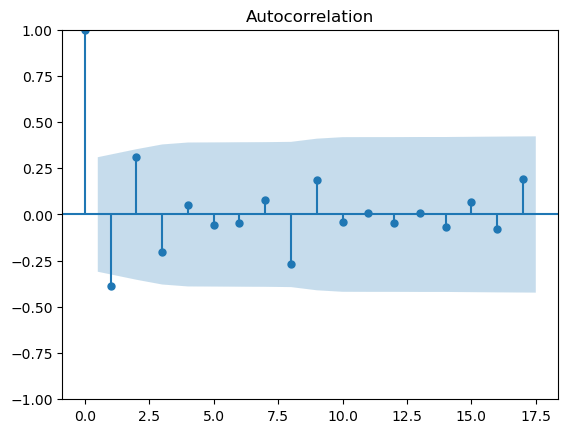

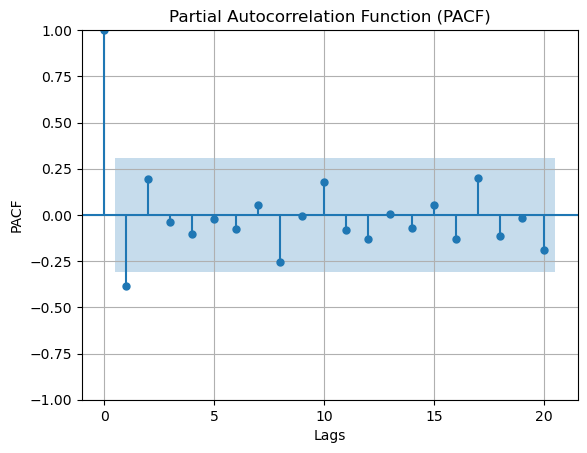

In [217]:
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import pacf
from statsmodels.graphics.tsaplots import plot_pacf

plot_acf(data['log_diff_P'])



pacf_values = pacf(data['log_diff_P'], nlags=20)

# Plot PACF
plot_pacf(data['log_diff_P'], lags=20)  # Change lags according to your data
plt.title('Partial Autocorrelation Function (PACF)')
plt.xlabel('Lags')
plt.ylabel('PACF')
plt.grid(True)
plt.show()

As can be seen from the figures above, the 0th lags are both 1, which makes perfect sense, and any other result should give you a sneaking sensation that something is materially wrong. We also see that for both the ACF and PACF, they are statistically significant at lag 1, but not thereafter. This implies a structure of AR(1), which is also what is found to be the "best" model using Oxmetrics, both via information criteria and the GETS (General-to-specific) approach. 

In [218]:
import statsmodels.tsa.api as tsa
# Fit the ARMA model
# ARMA(p, q) where p is the order of the AR part and q is the order of the MA part
p, d, q = 1, 0, 0  # You can change these values based on ACF and PACF plots
arma_model = tsa.ARIMA(data['log_diff_P'], order=(p, d, q)).fit()

# Print the summary of the model
print(arma_model.summary())

                               SARIMAX Results                                
Dep. Variable:             log_diff_P   No. Observations:                   40
Model:                 ARIMA(1, 0, 0)   Log Likelihood                  -3.259
Date:                Sat, 19 Oct 2024   AIC                             12.519
Time:                        23:25:37   BIC                             17.586
Sample:                             0   HQIC                            14.351
                                 - 40                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0068      0.030     -0.227      0.820      -0.066       0.052
ar.L1         -0.3824      0.161     -2.374      0.018      -0.698      -0.067
sigma2         0.0686      0.020      3.514      0.0

c:\Users\victo\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\victo\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\victo\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Here we see the model estimation for the AR(1) model. The results match the ones found in OxMetrics pretty well. for the AR-1 term, it is -0.3824 vs. -0.3918 and std. error is -2.37 vs. -2.57. The log-likelihood is -3.259 vs. -3.583.

The Information criteria however, are enormously different. 
The AIC (Akaike Information Criterion) is 
$$(-2\hat{l}+2k)T^{-1}$$
$k=p+q+1$ and this should give 0.26-0.28 (somewhere in that range).

Statsmodels uses the definition of $-2*llf+\log(n\ obs)(1+df_{model}$ where $llf$ is probably the value of the log-likelihood function, and $1+df_{model}=k$ is defined as above. 

It should therefore be kept in mind, that we cannot compare the IC values directly from OxMetrics to Python.

Now that we have calibrated the model, we should make a forecast. 

c:\Users\victo\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\victo\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


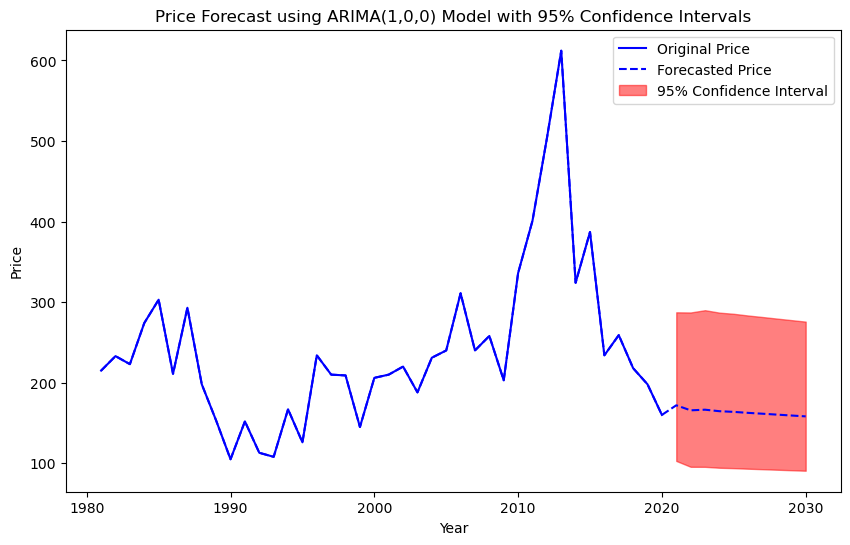

In [262]:
# 4. Forecasting future values with 95% confidence intervals
forecast_steps = 10
forecast_obj = arma_model.get_forecast(steps=forecast_steps)
forecast_mean = forecast_obj.predicted_mean
conf_int = forecast_obj.conf_int(alpha=0.05)  # 95% confidence intervals

# 5. Reverse the log difference to get the price forecast
# Start by taking the last known price
last_price = data['P'].iloc[-1]
forecast_prices = [last_price]

# Rebuild the price series from the forecasted log differences
for diff in forecast_mean:
    next_price = forecast_prices[-1] * np.exp(diff)
    forecast_prices.append(next_price)

# Remove the initial last_price used as starting point
forecast_prices = forecast_prices[1:]

# 6. Transform the confidence intervals
conf_int_transformed = []
previous_price = last_price  # Initialize with the last known actual price

# Loop through forecasted mean and confidence intervals
for i, (mean_ci_lower, mean_ci_upper) in enumerate(conf_int.values):
    # Lower and upper confidence intervals using the previous price (t-1)
    lower_price = previous_price * np.exp(mean_ci_lower)
    upper_price = previous_price * np.exp(mean_ci_upper)
    conf_int_transformed.append((lower_price, upper_price))
    
    # Update previous_price to the forecasted price at step t for the next iteration
    previous_price = forecast_prices[i]

# Split confidence intervals into lower and upper bounds
lower_bounds, upper_bounds = zip(*conf_int_transformed)

# 7. Plotting the results
plt.figure(figsize=(10, 6))

# Plot original price series
plt.plot(data['year'], data['P'], label='Original Price', color='blue')

# Create new arrays that include the last original price to connect to forecast
extended_years = np.append(data['year'].values, np.arange(data['year'].iloc[-1] + 1, data['year'].iloc[-1] + forecast_steps + 1))
extended_prices = np.append(data['P'].values, forecast_prices)

# Plot forecasted price series, starting with the last known price to connect smoothly
plt.plot(extended_years, extended_prices, label='Forecasted Price', color='blue', linestyle='--')

# Plot confidence intervals
forecast_years = np.arange(data['year'].iloc[-1] + 1, data['year'].iloc[-1] + forecast_steps + 1)
plt.fill_between(forecast_years, lower_bounds, upper_bounds, color='red', alpha=0.5, label='95% Confidence Interval')

# Add labels and legend
plt.xlabel('Year')
plt.ylabel('Price')
plt.title('Price Forecast using ARIMA(1,0,0) Model with 95% Confidence Intervals')
plt.legend()

# Show plot
plt.show()

The forecast is made with the calibrated model, and we then reverse the changes we have made originally, to make it stationary. This is done, since we do not really care about the forecast of the change in log-prices, but the forecast of the actual price. In the graph above, I have also added 95% confidence intervals. As we see, the forecast seems to revert to some value, which appears to be close the mean of the log-diff price.

We can also see that the the forecasted price is significantly lower than the government-suggested compensation price of 315,5 DKK, even up to a 95% confidence interval.



To expand on the GETS model selection, we can build a double for-loop, that iterates over ranges of possible values for $p$ and $q$, and then returns the model with the lowest information criterion. Here, I have chosen a range of 0-5 for both $p$ and $q$, and to use the BIC as the IC to minimize. We find that the ARMA(1,0) is still the best model to use.

In [264]:
import warnings 
data = data.dropna()
warnings.filterwarnings('ignore') 
# 3. Initialize variables to store the best model and lowest BIC
best_bic = np.inf  # Set initial BIC to a very large number
best_order = None  # Placeholder for the best (p, q) order
best_model = None  # Placeholder for the best model

# 4. Loop through combinations of p and q from 0 to 5 to find the best ARMA model
for p in range(6):
    for q in range(6):
        try:
            # Fit an ARMA(p, 0, q) model
            model = tsa.ARIMA(data['log_diff_P'], order=(p, 0, q)).fit()
            
            # Check if this model has a lower BIC
            bic = model.bic
            if bic < best_bic:
                best_bic = bic
                best_order = (p, q)
                best_model = model
        except Exception as e:
            # Ignore models that fail to fit
            continue

# 5. Output the best model and its order
print(f"Best model: ARMA{best_order} with BIC = {best_bic}")

# Optionally: print the summary of the best model
print(best_model.summary())

Best model: ARMA(1, 0) with BIC = 17.585548245020966
                               SARIMAX Results                                
Dep. Variable:             log_diff_P   No. Observations:                   40
Model:                 ARIMA(1, 0, 0)   Log Likelihood                  -3.259
Date:                Sun, 20 Oct 2024   AIC                             12.519
Time:                        01:46:07   BIC                             17.586
Sample:                             0   HQIC                            14.351
                                 - 40                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0068      0.030     -0.227      0.820      -0.066       0.052
ar.L1         -0.3824      0.161     -2.374      0.018      -0.698      -0.067